In [1]:
import sys
print(sys.version)

3.9.6 (default, Aug 18 2021, 11:08:34) 
[GCC 4.8.5 20150623 (Red Hat 4.8.5-44)]


In [3]:
import pandas as pd
import numpy as np
from scipy.stats import truncnorm
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor, DMatrix
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import random
from conditionalconformal import CondConf
import itertools
import math
from matplotlib.patches import Patch
from scipy.spatial import ConvexHull

''' import functions and values from different modules '''
from coverage import conformal_predict_z_0
from data_generation import z_domain, prepare_data_for_regression, function_1, dimension_x, dimension_z, number_z
from conformal_auxiliary import phi_fn
from Myerson_auction import myerson_reserve
from simu_exp import conformal_predict

- Realization of Figure 4(c) in Section 7.2

In [4]:
'''
Calculate the coverage probability of the conformal prediction interval for the values in a new auction, using different numbers of data points.
'''

'''N = 1000'''
np.random.seed(1)
Z_new = z_domain[np.random.randint(z_domain.shape[0])]
IR_1000, d_1000 = conformal_predict_z_0(alpha=0.1, m=50, Z_new=Z_new, N=1000, t=1000)

'''N = 3000'''
np.random.seed(1)
Z_new = z_domain[np.random.randint(z_domain.shape[0])]
IR_3000, d_3000 = conformal_predict_z_0(alpha=0.1, m=50, Z_new=Z_new, N=3000, t=1000)

'''N = 5000'''
np.random.seed(1)
Z_new = z_domain[np.random.randint(z_domain.shape[0])]
IR_5000, d_5000 = conformal_predict_z_0(alpha=0.1, m=50, Z_new=Z_new, N=5000, t=1000)

'''N = 7000'''
np.random.seed(1)
Z_new = z_domain[np.random.randint(z_domain.shape[0])]
IR_7000, d_7000 = conformal_predict_z_0(alpha=0.1, m=50, Z_new=Z_new, N=7000, t=1000)

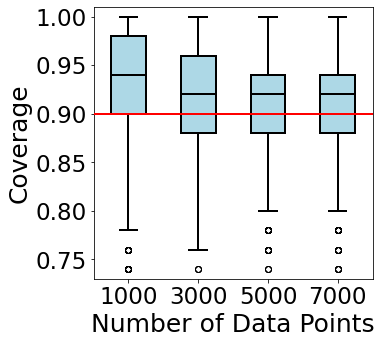

In [5]:
'''
Draw the boxplots of the coverage probability (Figure 4(c))
'''

N_values = [1000, 3000, 5000, 7000]


fig = plt.figure(figsize=(5, 5))
plt.boxplot([IR_1000, IR_3000, IR_5000, IR_7000], patch_artist=True, 
            medianprops=dict(color="black", linewidth=2,zorder=4),  
            boxprops=dict(facecolor='lightblue', linewidth=2),  
            whiskerprops=dict(linewidth=2),  
            capprops=dict(linewidth=2),widths=0.5, labels=N_values)  

plt.yticks( fontsize=23)
plt.xticks([1], [''])  # Setting x-axis label to an empty string

plt.xlabel("Number of Data Points", fontsize=25)
plt.ylabel('Coverage', fontsize=25)
plt.xticks(range(1, len(N_values) + 1), N_values, fontsize=23)
plt.ylim(0.73,1.01)
plt.axhline(y=0.9, color='red', linestyle='-', label='', linewidth=2,zorder=3)

- Realization of Figure 4(b) in Section 7.2

In [6]:
'''
Calculate the revenue from different mechanisms with varying numbers of data points in 1000 experiments.
'''

np.random.seed(1)
random.seed(1)

# Set different values for N
N_values = [1000, 3000, 5000, 7000, 9000, 11000, 13000]
Z_new = z_domain[np.random.randint(z_domain.shape[0])]
num_runs = 1000

# Initializes the dictionary used to store the results
results_list = []  

# For each value of N, run the function 1000 times 
for N in N_values:
    # Historical data generation
    data_points = []
    for _ in range(N):
        # Randomly select a vector from z_domain to be Z
        Z = z_domain[np.random.randint(z_domain.shape[0])]
        # Compute the mean of the square of Z
        mean_x = np.mean(Z**2)
        # Generate a 100-dimensional vector X from a normal distribution with mean mean_x and variance 1
        X = np.random.normal(mean_x, 1, dimension_x)
        # Compute T_1 using the generated functions
        T_1 = function_1(X, Z)
        # Append the data point (X, Z, T_1) to the list
        data_points.append([X, Z, T_1])
    # Split the data into D_cali and D_train
    D_cali = pd.DataFrame(data_points[:N//2], columns=["X", "Z", "T_1"])
    D_train = pd.DataFrame(data_points[N//2:], columns=["X", "Z", "T_1"])
    
    ############################################################################################ 
    ''' The Empirical Myerson Auction '''
    D_myerson = pd.DataFrame(data_points, columns=["X", "Z", "T_1"])
    # Select from historical data that has bid on new items
    df_myerson =  D_myerson[D_myerson["Z"].apply(lambda z: np.array_equal(z, Z_new))]
    # Calculate a single reserve price using historical data, treating all bidders as symmetric
    myerson_reserve_price = myerson_reserve(df_myerson)
    ############################################################################################

    ''' COAD implementation '''
    # Preparing data for regression
    X_train = prepare_data_for_regression(D_train)
    # Extracting the values from the training data
    T_1_train = D_train['T_1']
    # Using a polynomial model 
    poly = PolynomialFeatures(degree=2)
    X_train_poly = poly.fit_transform(X_train)
    # Training the model
    model = LinearRegression()
    model.fit(X_train_poly, T_1_train)

    ############################################################################################
    
    ''' Revenue calculation '''
    payments, myerson_values, sb_values, max_welfares = [], [], [], []
    for _ in range(num_runs):
        payment, myerson_value, sb_value, max_welfare = conformal_predict(0.1, 50, Z_new, myerson_reserve_price, model, D_cali, poly)
        # Revenue of COAD
        payments.append(payment)
        # Revenue of empirical Myerson auction
        myerson_values.append(myerson_value)
        # Revenue of second-price auction
        sb_values.append(sb_value)
        # Maximum social welfare
        max_welfares.append(max_welfare)
     # Store the results for each N in a separate dictionary
    results = {"N": N, "payment": payments, "myerson_values": myerson_values, "sb_value": sb_values, "max_welfare":max_welfares}
    results_list.append(results)

In [7]:
'''
Calculate the average revenue of different mechanisms under different number of data points, and add the error bars
'''

N_values = []
payments_means, payments_stds = [], []
sb_values_means, sb_values_stds = [], []
max_welfare_means, max_welfare_stds = [], []
myerson_means, myerson_stds = [], []


for entry in results_list:
    N_values.append(entry['N'])
    payments_means.append(np.mean(entry['payment']))
    payments_stds.append(1.96*np.std(entry['payment']) / np.sqrt(len(entry['payment'])))
    sb_values_means.append(np.mean(entry['sb_value']))
    sb_values_stds.append(1.96*np.std(entry['sb_value']) / np.sqrt(len(entry['sb_value'])))
    max_welfare_means.append(np.mean(entry['max_welfare']))
    max_welfare_stds.append(1.96*np.std(entry['max_welfare']) / np.sqrt(len(entry['max_welfare'])))
    myerson_means.append(np.mean(entry['myerson_values']))
    myerson_stds.append(1.96*np.std(entry['myerson_values']) / np.sqrt(len(entry['myerson_values'])))

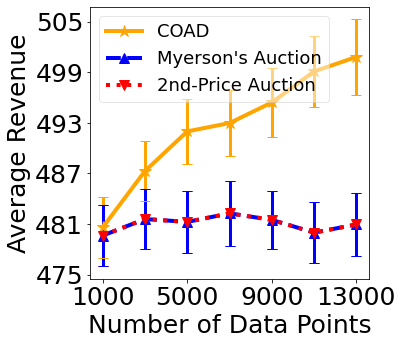

In [8]:
''' Draw the Figure 4(b) in Section 7.2 '''

import matplotlib.pyplot as plt

plt.figure(figsize=(5,5))

plt.plot(N_values, payments_means,label="COAD", color='orange', linestyle='-', marker='*', linewidth=4,markersize=12)
plt.plot(N_values, myerson_means, label="Myerson's Auction", color='blue', linestyle='--', marker='^', linewidth=4,markersize=10)
plt.plot(N_values, sb_values_means, label="2nd-Price Auction", color='red', linestyle=':', marker='v', linewidth=4,markersize=10)

plt.errorbar(N_values, payments_means, yerr=payments_stds, fmt='none', ecolor='orange', capsize=5, elinewidth=3)
plt.errorbar(N_values, sb_values_means, yerr=sb_values_stds, fmt='none', ecolor='red',capsize=5, elinewidth=3)
plt.errorbar(N_values, myerson_means, yerr=myerson_stds, fmt='none', ecolor='blue',capsize=5, elinewidth=3)

plt.xlabel("Number of Data Points", fontsize=25)
plt.ylabel("Average Revenue", fontsize=25)
plt.legend(fontsize=18, facecolor='white', framealpha=0.5)
plt.yticks(fontsize=25)
plt.xticks(fontsize=25)
plt.xticks([1000, 5000, 9000, 13000])
plt.yticks([475, 481, 487, 493, 499, 505])
plt.show()

- Realization of Figure 4(a) in Section 7.2

In [9]:
np.random.seed(1)
random.seed(1)
Z_new = z_domain[np.random.randint(z_domain.shape[0])]
data_points = []
N = 20000

# Historical data generation
for _ in range(N):
    # Randomly select a vector from z_domain to be Z
    Z = z_domain[np.random.randint(z_domain.shape[0])]
    # Compute the mean of the square of Z
    mean_x = np.mean(Z**2)
    # Generate a 100-dimensional vector X from a normal distribution with mean mean_x and variance 1
    X = np.random.normal(mean_x, 1, dimension_x)
    # Compute the true values using the generated functions
    T_1 = function_1(X, Z)
    # Append the data point (X, Z, T_1) to the list
    data_points.append([X, Z, T_1])
    
# Split the data into D_cali and D_train
D_cali = pd.DataFrame(data_points[:N//2], columns=["X", "Z", "T_1"])
D_train = pd.DataFrame(data_points[N//2:], columns=["X", "Z", "T_1"])

############################################################################################ 
''' The Empirical Myerson Auction '''
D_myerson = pd.DataFrame(data_points, columns=["X", "Z", "T_1"])
# Select from historical data that has bid on this new item
df_myerson =  D_myerson[D_myerson["Z"].apply(lambda z: np.array_equal(z, Z_new))]
# Calculate a single reserve price using historical data, treating all bidders as symmetric
myerson_reserve_price = myerson_reserve(df_myerson)
############################################################################################
    
    
# Preparing data for regression
X_train = prepare_data_for_regression(D_train)
# Extracting the values from the training data
T_1_train = D_train['T_1']
# Using a polynomial model 
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train)
# Training the model
model = LinearRegression()
model.fit(X_train_poly, T_1_train)
num_runs = 1000

In [10]:
''' 
For each value of m, run the experiments 1000 times and save the revenue of different mechanims 
'''

# Set different values for m (number of bidders)
m_values = list(range(50, 301, 50))
np.random.seed(1)
random.seed(1)
Z_new = z_domain[np.random.randint(z_domain.shape[0])]
num_runs = 1000
# This will store the results for each m value
results_list_m = []

# For each m value, run the function 1000 times and calculate the average
for m in m_values:
    payments, myerson_values, sb_values, max_welfares = [], [], [], []
    for _ in range(num_runs):
        payment, myerson_value, sb_value, max_welfare = conformal_predict(0.1, m, Z_new,  myerson_reserve_price, model, D_cali, poly)
        # Revenue of COAD
        payments.append(payment)
        # Revenue of empirical Myerson auction
        myerson_values.append(myerson_value)
        # Revenue of second-price auction
        sb_values.append(sb_value)
        # Maximum social welfare
        max_welfares.append(max_welfare)
    
    # Create a dictionary for each m with the results and append to the list
    results = {"m": m, "payment": payments, "myerson_values": myerson_values, "sb_value": sb_values, "max_welfare": max_welfares}
    results_list_m.append(results)
    


In [11]:
'''
Calculate the average revenue of different mechanisms under different number of bidders, and add the error bars
'''

m_values = []
payment_means = []
payment_ses = []
sb_value_means = []
sb_value_ses = []
max_welfare_means = []
max_welfare_ses = []
myerson_means, myerson_ses = [], []

for entry in results_list_m:
    m_values.append(entry['m'])
    payment_means.append(np.mean(entry['payment']))
    payment_ses.append(1.96 * np.std(entry['payment']) / np.sqrt(len(entry['payment'])))
    sb_value_means.append(np.mean(entry['sb_value']))
    sb_value_ses.append(1.96 * np.std(entry['sb_value']) / np.sqrt(len(entry['sb_value'])))
    max_welfare_means.append(np.mean(entry['max_welfare']))
    max_welfare_ses.append(1.96 * np.std(entry['max_welfare']) / np.sqrt(len(entry['max_welfare'])))
    myerson_means.append(np.mean(entry['myerson_values']))
    myerson_ses.append(1.96*np.std(entry['myerson_values']) / np.sqrt(len(entry['myerson_values'])))

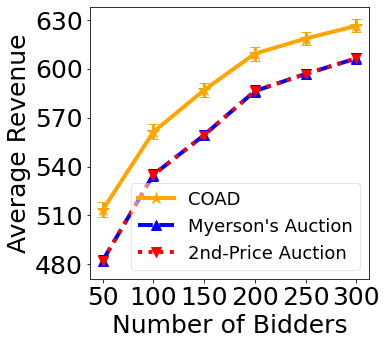

In [12]:
''' Draw the Figure 4(a) in Section 7.2'''


plt.figure(figsize=(5, 5))
plt.plot(m_values, payment_means, label="COAD",  color='orange', linestyle='-', marker='*', linewidth=4,markersize=12)
plt.plot(m_values, myerson_means, label="Myerson's Auction",  color='blue', linestyle='--', marker='^', linewidth=4,markersize=10)
plt.plot(m_values, sb_value_means, label="2nd-Price Auction",  color='red', linestyle=':', marker='v', linewidth=4,markersize=10)

plt.errorbar(m_values, payment_means, yerr=payment_ses, fmt='none', ecolor='orange', capsize=5, elinewidth=3)
plt.errorbar(m_values, sb_value_means, yerr=sb_value_ses,fmt='none', ecolor='red', capsize=5, elinewidth=3)
plt.errorbar(m_values, myerson_means, yerr=myerson_ses,fmt='none', ecolor='blue', capsize=5, elinewidth=3)


plt.xlabel("Number of Bidders", fontsize=25)
plt.ylabel("Average Revenue", fontsize=25)
plt.yticks(fontsize=25)
plt.xticks(fontsize=25)
plt.yticks([480, 510,540,570,600, 630])
plt.title("")
plt.legend(fontsize=18, loc="lower right", facecolor='white', framealpha=0.5)
plt.show()